In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier # using 1NN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm 
from torchvision.utils import make_grid
from torchvision.utils import save_image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Download the [cow teat datasets](https://github.com/YoushanZhang/SCTL) (10 points) resize image to (224, 224)

### (1). Create a train data loader that returns image arrays and labels

In [39]:
def train_data_loader(train_dirs):
    # Initialize empty lists for to store image arrays and labels
    image_arrays = []
    image_labels = []
   
    # loop to navitage all directories and read information from all the image files
    for label, directory in enumerate(sorted(os.listdir(train_dirs))):
        path = os.path.join(train_dirs, directory)

        # check if it's a directory
        if not os.path.isdir(path):
            continue

        # Iterate over image files in the directory
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)

            # resize and store images
            img = cv2.resize(plt.imread(img_path).copy(), (75, 75))
            image_labels.append(label)
            image_arrays.append(img)
            
    return image_arrays, image_labels

### (2). Create a test data loader that returns image arrays and file names

In [40]:
def test_data_loader(data_dir):
    # Get a list of image files in the test data directory
    image_files = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
    
    # Initialize lists for data and file names
    image_arrays = []
    image_names = []
    
    # Iterate over the image files
    for file in image_files:
        # Get the full path of the image
        path = os.path.join(data_dir, file)
        
        # Read and preprocess the image
        img = cv2.resize(plt.imread(path).copy(), (75, 75))
        #img = img.astype(np.float32) / 255.0
        
        # Append the preprocessed image and file name to the lists
        image_arrays.append(img)
        image_names.append(file)
    
    # Convert lists to NumPy arrays and return
    return image_arrays, image_names


### (3). Print image arrays, labels and file names dimensions 

### Training Dataset

In [41]:
train_loader = r'C:\AKA\Backup Dell Laptop\D Drive\YU\Semester 2\Neural Network\DLNN\Assignment_Week5\Homework Week5\Homework Week5\Training'
training_array, training_labels = train_data_loader(train_loader)
training_array, training_labels = np.array(training_array), np.array(training_labels)

print("Training Dataset Array:",training_array.shape )
print("Training Label Shape:",training_labels.shape )

Training Dataset Array: (1149, 75, 75, 3)
Training Label Shape: (1149,)


In [42]:
training_labels

array([0, 0, 0, ..., 3, 3, 3])

**Observation:**
   - The training dataset contains total 1149 images of size 224, 224 and has 3 channels.

### Test Dataset

In [43]:
# Example usage
test_loader=r'C:\AKA\Backup Dell Laptop\D Drive\YU\Semester 2\Neural Network\DLNN\Assignment_Week5\Homework Week5\Homework Week5\Test_Data'
test_array, test_file_name = test_data_loader(test_loader)
test_array, test_file_name = np.array(test_array), np.array(test_file_name)

print("Test Dataset Array:",test_array.shape )
print("Test File Names Extracted:",test_file_name.shape )


Test Dataset Array: (380, 75, 75, 3)
Test File Names Extracted: (380,)


**Observation:**
   - The test dataset contains total 380 images of size 224, 224 and has 3 channels.

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np

In [48]:
import torch.nn as nn

class ImprovedNeuralNetwork(nn.Module):
    def __init__(self):
        super(ImprovedNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 18 * 18, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(64, 4)  # Replace 'num_classes' with the number of classes in your dataset

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x


In [49]:
# Initialize your neural network (no arguments needed)
model = ImprovedNeuralNetwork()

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [50]:
# Assuming you have loaded your training data into 'training_array' and 'training_labels'



# Convert data to PyTorch tensors
training_data = torch.Tensor(training_array)
training_labels = torch.LongTensor(training_labels)

# Define the number of classes (replace with the actual number)
num_classes = 10  # Change to your actual number of classes


# # Set the device (CPU or GPU)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print(device)

device='cpu'


# Assuming 'training_data' has shape [1149, 224, 224, 3]
# You can permute the dimensions to match the expected shape [1149, 3, 224, 224]
training_data = training_data.permute(0, 3, 1, 2)


# Training loop
num_epochs = 30  # You can adjust this as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(training_data.to(device))
    loss = criterion(outputs, training_labels.to(device))
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')


Epoch [1/30], Loss: 1.5768401622772217
Epoch [2/30], Loss: 32.6455078125
Epoch [3/30], Loss: 22.35588264465332
Epoch [4/30], Loss: 23.18600845336914
Epoch [5/30], Loss: 4.770748138427734
Epoch [6/30], Loss: 2.5989785194396973
Epoch [7/30], Loss: 1.7546974420547485
Epoch [8/30], Loss: 1.334102749824524
Epoch [9/30], Loss: 1.0960060358047485
Epoch [10/30], Loss: 1.1645104885101318
Epoch [11/30], Loss: 1.2103387117385864
Epoch [12/30], Loss: 1.1658682823181152
Epoch [13/30], Loss: 1.0876150131225586
Epoch [14/30], Loss: 1.0576586723327637
Epoch [15/30], Loss: 1.0383129119873047
Epoch [16/30], Loss: 1.0156052112579346
Epoch [17/30], Loss: 0.9868711233139038
Epoch [18/30], Loss: 0.9644086956977844
Epoch [19/30], Loss: 0.91826993227005
Epoch [20/30], Loss: 0.9073477983474731
Epoch [21/30], Loss: 0.8776290416717529
Epoch [22/30], Loss: 0.8501132130622864
Epoch [23/30], Loss: 0.8431546092033386
Epoch [24/30], Loss: 0.7938212752342224
Epoch [25/30], Loss: 0.7754685282707214
Epoch [26/30], Loss:

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import pandas as pd

# Define your neural network class

# Define your data loading functions

# Load your trained model
model = ImprovedNeuralNetwork()
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set the model to evaluation mode

# Assuming 'test_array' has shape [num_samples, 224, 224, 3]
test_data = torch.Tensor(test_array).permute(0, 3, 1, 2)

# Make predictions on the test data
with torch.no_grad():
    test_outputs = model(test_data)

# Get the predicted labels (assuming you are using softmax as the final layer)
_, predicted_labels = torch.max(test_outputs, 1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'test_file_names': test_file_name,
    'predicted_labels': predicted_labels
})

# Save the results to a CSV file
results_df.to_csv('prediction_result.csv', index=False, header=False)

print("Results saved to prediction_result.csv")

Results saved to prediction_result.csv


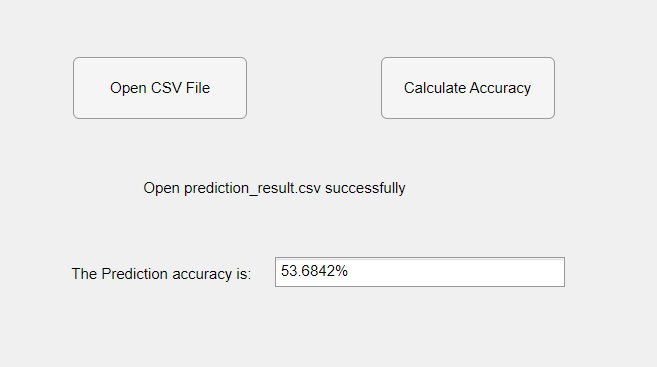